# **Initilization**

## **Connecting GDrive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Testing TensorFlow and GPU**

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
2.5.0


## **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.random.seed(1337)  # for reproducibility
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Embedding, LSTM, SimpleRNN, GRU
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from keras.utils.np_utils import to_categorical
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder

%matplotlib inline


# **Data Preparation**

## **Importing Dataset**

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/M.Tech Project/Dataset and Codes/CIC IDS 2018/cic-ids-2018-multiclass.csv")
dataset = dataset.drop(['Unnamed: 0', 'label'],axis=1)

In [ ]:
## Separating the Dependent and Independent Variables ##
X = dataset.iloc[:, :-1]
Y = dataset.iloc[:,-1]
## Splitting Data into Train and Test Set ##
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)
##Normalizing the X_train ##
scaler = Normalizer().fit(X_train)
X_train = scaler.transform(X_train)
##Normalizing the X_test ##
scaler = Normalizer().fit(X_test)
X_test = scaler.transform(X_test)
## SMOTE for Training Data ##
from imblearn.over_sampling import SMOTE
strategy = {5:10000, 8:10000, 4:10000, 1:20000, 2:20000, 11:20000}
oversample = SMOTE(sampling_strategy = strategy)
X_train, Y_train = oversample.fit_resample(X_train, Y_train)
## SMOTE for Test Samples
from imblearn.over_sampling import SMOTE
strategy = {1:2000, 2:2000, 11:2000}
oversample = SMOTE(sampling_strategy = strategy)
X_test, Y_test = oversample.fit_resample(X_test, Y_test)
## Converting into Numpy Array ##
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
## Converting the output variable into Categorical Vectors
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

# **DNN**

## **Training The Model**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


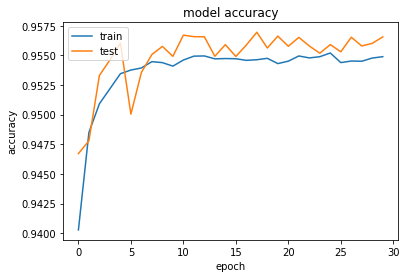

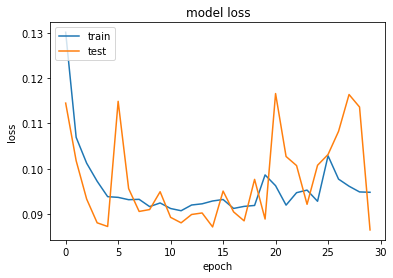

In [ ]:
# 1. define the network
model = Sequential()
model.add(Dense(1024,input_dim=78,activation='relu'))  
model.add(Dropout(0.01))
model.add(Dense(768,activation='relu'))  
model.add(Dropout(0.01))
model.add(Dense(512,activation='relu'))  
model.add(Dropout(0.01))
model.add(Dense(256,activation='relu'))  
model.add(Dropout(0.01))
model.add(Dense(128,activation='relu'))  
model.add(Dropout(0.01))
model.add(Dense(13))
model.add(Activation('softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
with tf.device('/device:GPU:0'):
  model_history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=64, epochs=30, verbose=0)
print(model_history.history.keys())
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Model Evaluation**

In [ ]:
model.evaluate(X_test,Y_test)

13568/13568 [==============================] - 28s 2ms/step - loss: 0.0865 - accuracy: 0.9566


[0.08649487048387527, 0.956554114818573]

In [ ]:
## Testing Model
Y_predicted = np.round(model.predict(X_test))
Y_predicted = np.reshape(Y_predicted, Y_test.shape)

In [ ]:
## Generating Classification Report on the Predicted vs Actual Value
print(classification_report(Y_test, Y_predicted))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57238
           1       0.00      0.00      0.00      2000
           2       1.00      0.47      0.64      2000
           3       1.00      1.00      1.00    137203
           4       1.00      1.00      1.00       346
           5       0.92      1.00      0.95      8302
           6       1.00      1.00      1.00     92382
           7       0.75      0.51      0.61     27978
           8       0.98      0.97      0.97      2198
           9       0.71      0.88      0.79     38671
          10       0.92      0.98      0.95     32128
          11       0.00      0.00      0.00      2000
          12       1.00      1.00      1.00     37518

   micro avg       0.95      0.95      0.95    439964
   macro avg       0.79      0.75      0.76    439964
weighted avg       0.94      0.95      0.94    439964
 samples avg       0.95      0.95      0.95    439964



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## Generating the Confusion Matrix
cm = confusion_matrix(Y_test.argmax(axis=1), Y_predicted.argmax(axis=1))
print(cm)

[[ 57230      0      1      0      0      0      0      0      0      0
       7      0      0]
 [  1029      0      0      0      0    227      0      0      0      0
     740      0      4]
 [   152      0    949      0      0      0      0      0      0      0
     899      0      0]
 [     0      0      0 137203      0      0      0      0      0      0
       0      0      0]
 [     0      0      0      0    346      0      0      0      0      0
       0      0      0]
 [     5      0      0      0      0   8276      2      0     13      0
       6      0      0]
 [   129      0      0      0      0      0  92248      0      0      0
       5      0      0]
 [     0      0      0      0      0      0      0  14254      0  13724
       0      0      0]
 [    49      0      0      1      0      0      1      0   2132      0
      15      0      0]
 [     0      0      0      0      0      0      0   4654      0  34017
       0      0      0]
 [   265      0      3      8      0    

In [ ]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [ ]:
# True positive rate
TPR = TP/(TP+FN)
TPR

array([0.99973794, 0.2215    , 0.3445    , 1.        , 0.99710983,
       0.99771139, 0.99992423, 0.50493245, 0.95131938, 0.88991751,
       0.99028884, 0.        , 0.99968015])

In [ ]:
# True negative rate
TNR = TN/(TN+FP) 
TNR

array([0.99579856, 0.9997808 , 1.        , 0.99969943, 1.        ,
       0.99860076, 0.99934404, 0.9894778 , 0.99992233, 0.96539436,
       0.99371071, 1.        , 0.99999752])

In [ ]:
# Precision
PPV = TP/(TP+FP)
PPV

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([0.97266747, 0.82189239, 1.        , 0.99933719, 1.        ,
       0.93203556, 0.99753788, 0.76519337, 0.984     , 0.71249042,
       0.92539484,        nan, 0.99997334])

In [ ]:
# Negative predictive value
NPV = TN/(TN+FN)
NPV

array([0.99996064, 0.99645673, 0.99701554, 1.        , 0.99999773,
       0.99995592, 0.99997985, 0.96713895, 0.99975562, 0.98913096,
       0.99923074, 0.99545417, 0.99997018])

In [ ]:
# False positive rate
FPR = FP/(FP+TN)
FPR

array([4.20143915e-03, 2.19196098e-04, 0.00000000e+00, 3.00567114e-04,
       0.00000000e+00, 1.39924293e-03, 6.55960320e-04, 1.05222022e-02,
       7.76670641e-05, 3.46056373e-02, 6.28929275e-03, 0.00000000e+00,
       2.48480541e-06])

In [ ]:
# False negative rate
FNR = FN/(TP+FN)
FNR

array([2.62063664e-04, 7.78500000e-01, 6.55500000e-01, 0.00000000e+00,
       2.89017341e-03, 2.28860516e-03, 7.57723366e-05, 4.95067553e-01,
       4.86806187e-02, 1.10082491e-01, 9.71115538e-03, 1.00000000e+00,
       3.19846474e-04])

In [ ]:
# False discovery rate
FDR = FP/(TP+FP)
FDR

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([2.73325288e-02, 1.78107607e-01, 0.00000000e+00, 6.62811193e-04,
       0.00000000e+00, 6.79644424e-02, 2.46212326e-03, 2.34806630e-01,
       1.60000000e-02, 2.87509575e-01, 7.46051598e-02,            nan,
       2.66616898e-05])

In [ ]:
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC

array([0.99631106, 0.99624287, 0.99702021, 0.99979316, 0.99999773,
       0.99858398, 0.99946587, 0.9586648 , 0.99967952, 0.95876026,
       0.99346083, 0.99545417, 0.99997045])